<a href="https://colab.research.google.com/github/sidhusmart/CoRise_Prompt_Design_Course/blob/cohort3/Week_1/CoRise_Week1_StudentVersion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Putting all the pieces together to deploy your product


In [1]:
## Setting up the necessary dependencies
!pip uninstall typing-extensions -y
!pip uninstall gradio -y
!pip install typing_extensions==4.7.1
!pip install gradio
!pip install feedparser
!pip install transformers accelerate
!pip install openai
!pip install tiktoken
!pip install pypdf

Found existing installation: typing_extensions 4.10.0
Uninstalling typing_extensions-4.10.0:
  Successfully uninstalled typing_extensions-4.10.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 13.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.9/307.9 kB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 80.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.9 MB/s eta 0:00:00
     ━

# Section 4 - Putting all the pieces together to deploy your product

## Encapsulating features into functions

We put all the functionality that we have developed till now into easy to use functions. To simplify things, we read all the pages of the PDF as opposed to the selected pages examples that we showed in Section 1.

Feel free to modify the functions as necessary to suit the product you want to build. Also take a look at the Extensions section where we present additional ideas and code examples for dealing with other data sources.

In [5]:
import os
from openai import OpenAI
import tiktoken

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

from pypdf import PdfReader, PageRange

from google.colab import userdata

client = OpenAI(api_key=userdata.get('test_new'))

## Function to read the uploaded PDF
def read_data_from_PDF(input_path):
  input_text = ''
  print ('Reading PDF from path', input_path)
  reader = PdfReader(input_path)
  number_of_pages = len(reader.pages)
  print ('PDF has been read with ', number_of_pages, ' pages')
  for page in reader.pages:
    input_text += page.extract_text() + "\n"
  return input_text


## Function to split the text into sentences
def split_text (input_text):
  split_texts = sent_tokenize(input_text)
  return split_texts


## Function to create chunks while considering sentences
def create_chunks(split_sents, max_token_len=50):
  enc = tiktoken.encoding_for_model("gpt-3.5-turbo")
  current_token_len = 0
  input_chunks = []
  current_chunk = ""
  for sents in split_sents:
    sent_token_len = len(enc.encode(sents))
    if (current_token_len + sent_token_len) > max_token_len:
      input_chunks.append(current_chunk)
      current_chunk = ""
      current_token_len = 0
    current_chunk = current_chunk + sents
    current_token_len = current_token_len + sent_token_len
  if current_chunk != "":
    input_chunks.append(current_chunk)
  return input_chunks


## Function to create chunks
def create_input_chunks(input_text):
  split_sents = split_text(input_text)
  input_chunks = create_chunks(split_sents, max_token_len=3000)
  return input_chunks


## Function to create summary of the given input text
def create_summary_points(input_chunks):
  client = OpenAI(api_key=userdata.get('test_new'))
  instructPrompt = """
                  Summarize the key points of the Women’s Movement and Feminism in Central Asia, highlighting historical challenges, current issues, and potential strategies for progress. Structure the summary to engage a podcast audience with progressive and anti colonial values and also make it sound casual.

                  - Highlight historical events
                  - Highlight uniqness of the culture and problems
                  - Make it less generalized
                  """
  podcastFacts = []
  for text in input_chunks:
    request = instructPrompt + '\n' + text
    chatOutput = client.chat.completions.create(model="gpt-3.5-turbo",
                                            messages=[{"role": "system", "content": "You are a helpful assistant."},
                                                      {"role": "user", "content": request}
                                                      ]
                                            )
    podcastFacts.append(chatOutput.choices[0].message.content)
  return "\n".join(podcastFacts)


## Two different prompt styles for the podcast conversation
debate_podcast_prompt = """
Could you simulate a podcast conversation in a debate-style between two women, \"Aisulu\" and \"AI\", discussing the following key points extracted from a research paper?
Some things that you need to keep in mind while creating the conversation:
- In the debate, Aisulu takes a stance that has a positive view of the findings and supports the implications and findings represented by these key points. They provide their reasoning and analogical examples to back up their interpretations.
- Conversely, AI adopts a more critical or alternative viewpoint. They question some of the findings by discussing potential drawbacks, limitations, or different outcomes.
- The conversation should see both experts engaging with each key point, presenting their views, challenging each other's interpretations, and discussing the broader implications of their arguments.
- The debate should be balanced, allowing each expert to articulate their perspective comprehensively.
- Conclude the conversation with each expert summarizing their overall position on the topic.
Here's some of the facts from the topic.
Kazakhstan are by no means passive subjects of the regime and the patriarchy.
Women become victims of gender-based violence and the government is not in a hurry to protect them and challenge its patriarchal structure.
Kazakhstani women marching against VAW and sexism on 8 March 2020 in Almaty Kazakhstan.
"""

casual_podcast_prompt = """
Could you simulate a podcast conversation between two friends \"Aisulu\" and \"AI\" having a conversation about the following facts?
Some things I'd like to ask:
  - Use \"Aisulu:\" and \"AI:\" to indicate who is speaking. Start the dialog with a casual discussion on where each person is from
  - Start the dialog with a casual discussion on what each person's hobby is right now.
  - Make the dialog about this as long as possible and make it sound funny
  - Sid is the one presenting the information, AI is asking intelligent questions that help Aisulu elaborate the facts.
Here's some of the facts from the topic.
"""

styles = {'casual':casual_podcast_prompt,
          'debate': debate_podcast_prompt}


## Function to create the podcast script
def create_podcast_script(podcast_points, output_style):
  client = OpenAI(api_key=userdata.get('test_new'))
  instructPrompt = styles[output_style]
  request = instructPrompt + '\n' + podcast_points
  chatOutput = client.chat.completions.create(model="gpt-3.5-turbo-16k",
                                            messages=[{"role": "system", "content": "You are a helpful assistant."},
                                                      {"role": "user", "content": request}
                                                      ]
                                            )
  return chatOutput.choices[0].message.content


## Function to call all the podcast script generation steps
def create_podcast(input_path, output_style):
  input_text = read_data_from_PDF(input_path)
  input_chunks = create_input_chunks(input_text)
  podcastHighlights = create_summary_points(input_chunks)
  podcastScript = create_podcast_script(podcastHighlights, output_style)
  return podcastScript


## Function to generate speech from input text
def openai_generation(input_text, speaker_voice, model_choice="tts-1"):
  client = OpenAI(api_key=userdata.get('test_new'))
  response = client.audio.speech.create(
      model=model_choice,
      voice=speaker_voice,
      input=input_text
  )
  return response.read()


## Function to generate complete audio podcast from script
## NOTE: this function assumes that there are only two speakers; please modify if you have multiple speakers in the script
def create_podcast_audio(podcastScript, speakerName1="Aisulu", speakerChoice1='shimmer', speakerName2="AI", speakerChoice2='alloy'):
  genPodcast = []
  podcastLines = podcastScript.split('\n\n')
  podcastLineNumber = 0
  for line in podcastLines:
    if podcastLineNumber % 2 == 0:
      speakerChoice = speakerChoice1
      line = line.replace(speakerName1+":", '')
    else:
      speakerChoice = speakerChoice2
      line = line.replace(speakerName2+":", '')
    genVoice = openai_generation(input_text=line, speaker_voice=speakerChoice, model_choice="tts-1")
    genPodcast.append(genVoice)
    podcastLineNumber += 1
  with open("genPodcast.mp3", "wb") as f:
    for pod in genPodcast:
      f.write(pod)
  return "genPodcast.mp3"

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Creating a front-end application to host the app

We will create a front-end application with Gradio that allows any user to interact with our product. We have chosen to go with a basic UI experience but the idea is to show the power of the product.

When you run the code below, the Gradio front-end will be loaded and running in the notebook environment but also generate a URL that you can share with anyone who wants to use the app!

In [6]:
import gradio as gr

def upload_file(file):
    return file.name

with gr.Blocks() as demo:
    file_output = gr.File()
    upload_button = gr.UploadButton("Click to Upload a PDF", file_types=[".pdf"], file_count="single")
    upload_button.upload(upload_file, upload_button, file_output)
    podcast_style = gr.Dropdown(styles.keys(), label="podcast_style")
    generate_podcast_button = gr.Button("Generate Podcast Script")
    podcast_script = gr.Textbox(interactive=True, label="podcast_script")

    generate_podcast_button.click(fn=create_podcast, inputs=[file_output, podcast_style], outputs=podcast_script, api_name="generate_podcast_script")

    generate_audio_button = gr.Button("Generate Audio Version")
    podcast_audio = gr.Audio(label="podcast_audio", interactive=False, type="filepath")
    generate_audio_button.click(fn=create_podcast_audio, inputs=podcast_script, outputs=podcast_audio, api_name="generate_podcast_audio")

demo.launch(debug=True, share=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://7cc355b67c7e1878ec.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Reading PDF from path /tmp/gradio/3f1c1ca1698c94712d00fb837a9f77aa46c77e85/Womens Movement and Feminism in Central Asia 2.pdf
PDF has been read with  6  pages
Keyboard interruption in main thread... closing server.


KeyboardInterrupt: 

# Extensions

## Running a Local LLM

In this section, we present an alternative LLM option that can run locally. This will obviously have longer processing times but you will not be charged credits for using an API. Please note that this approach is experimental and will be more variable in terms of quality of output and speed. The libraries and tools are experimental in nature and can change at short notice. Our recommendation would be to stick with the default options presented above for a simple approach.

But we do present these options that you can run for free within a Colab notebook. This is an alternative way of completing the project for those who have run out of credits on OpenAI or do not want to attach a credit card for any reason.

**LLAMA-CPP**

In order to run a local LLM, we will make use of the [Llama-CPP-Python](https://github.com/abetlen/llama-cpp-python) package. In addition to OpenAI and Claude that are closed source models accecible only through an API, there are several open-source language models that are primarily derived from [LLAMA-2](https://llama.meta.com/) (from Meta) or [Mistral](https://mistral.ai/news/announcing-mistral-7b/). Since they are open-source, the community has fine-tuned on multiple datasets and created several versions that serve various purposes.

These models come in different sizes starting from a 7 Billion parmaeter model going upto 70 billion parameters. Even still, they are quite large and take up quite some GPU RAM when loaded. As a result, there is an initiative to quantize these models and provide them in C++ binaries that are much smaller in size and can easily fit into memory. On the other hand, they do loose some quality and can still take long to generate responses.

We start by installing the llama-cpp-python library with some additional options that make sure that we are using the GPU version that can leverage the T4 GPU available for free on Google Colab.

In [7]:
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.8/36.8 MB 28.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 5.7 MB/s eta 0:00:00
  Created wheel for llama-cpp-python: filename=llama_cpp_python-0.2.53-cp310-cp310-manylinux_2_35_x86_64.whl size=26104868 sha256=298cd9fa9daa78f8cbe5b46b543ccc0a87f4cdd3ca2f08b8af1e261d31755f15
  Stored in directory: /root/.cache/pip/wheels/56/94/10/5407d0fd0a979d77bef8df3d298af7d1d60193b6b759ad217f
Successfully built llama-cpp-python


Most of the quantized models are made available by a handle called [TheBloke](https://huggingface.co/TheBloke) on HuggingFace. They are available in multiple quantized format and we will not go into depth but suffice to say that we choose a version that can be loaded in memory and produces reasonable output.

For our project, we would recommend running the WizardLM-13B model that is currently rated high in the OpenLLM Chatbot [leaderboard](https://huggingface.co/spaces/lmsys/chatbot-arena-leaderboard). The code below downloads the WizardLM 13 Billion parameter model and stores it within the Google Colab directory.

In [8]:
from huggingface_hub import hf_hub_download
hf_hub_download(repo_id="TheBloke/WizardLM-13B-V1.2-GGUF", filename="wizardlm-13b-v1.2.Q4_K_S.gguf", local_dir='/content')

wizardlm-13b-v1.2.Q4_K_S.gguf:   0%|          | 0.00/7.41G [00:00<?, ?B/s]

'/content/wizardlm-13b-v1.2.Q4_K_S.gguf'

In [9]:
!pip install llama-cpp-python

In the following step, we are loading the downloaded model into GPU memory and setup some parameters like the context window, temperature etc. You can vary these based on your preferences but we have provided the recommended defaults.

In [15]:
from llama_cpp import Llama
n_gpu_layers = 13 # Change this value based on your model and your GPU VRAM pool.
llm = Llama(model_path="/content/wizardlm-13b-v1.2.Q4_K_S.gguf",
            temperature=0.75,
            max_tokens=6000,
            top_p=1,
            verbose=True,
            n_gpu_layers=n_gpu_layers,
            n_ctx=6000
)

The great thing about the llama-cpp-python library is that it provides very similar APIs to those provided by OpenAI. So the code for actually making the LLM call, should look very familiar to the original example provided above. The only change we make is to take only a part of the transcript since the context window of the local LLM is not as large as the 16k context window provided by GPT-3.5-Turbo.

## Deploy to HuggingFace

Deploy your product to HuggingFace and provide users with a way to use the app! The Gradio app that you created above will be valid as long as the Colab notebook us running. But it's a very easy step to deploy this to HuggingFace by creating your own Space.

- Create an account and sign-in to HuggingFace
- Then navigate to the Spaces tab and click on Create New Space
- You can provide the name of the app you would like to create, choose Gradio as the Space SDK and select whether you want to keep the app Private/Public
- On the next page, you can select the create the `app.py` file directly in the browser which should open up an editor window directly in the browser
- Now you need to copy-paste the code from the last two cells into app.py. The first cell contains all the encapsulated functions and the second cell contains the definition of the gradio app
- Once you've commited this change, your app will be built and available to be used by anyone!

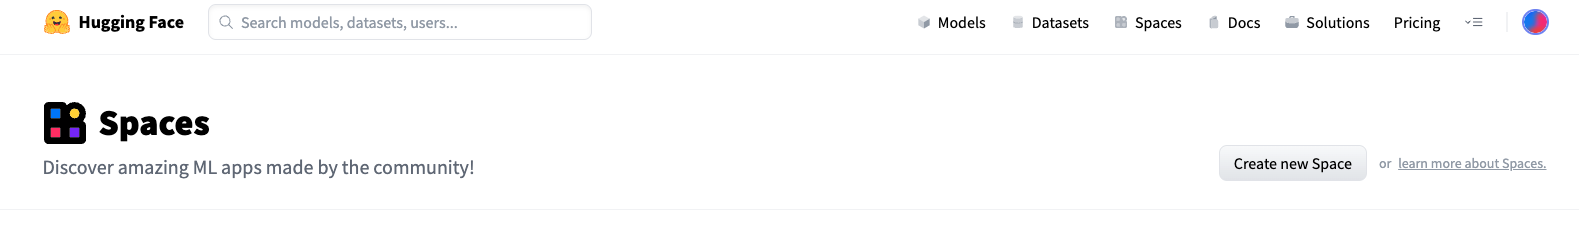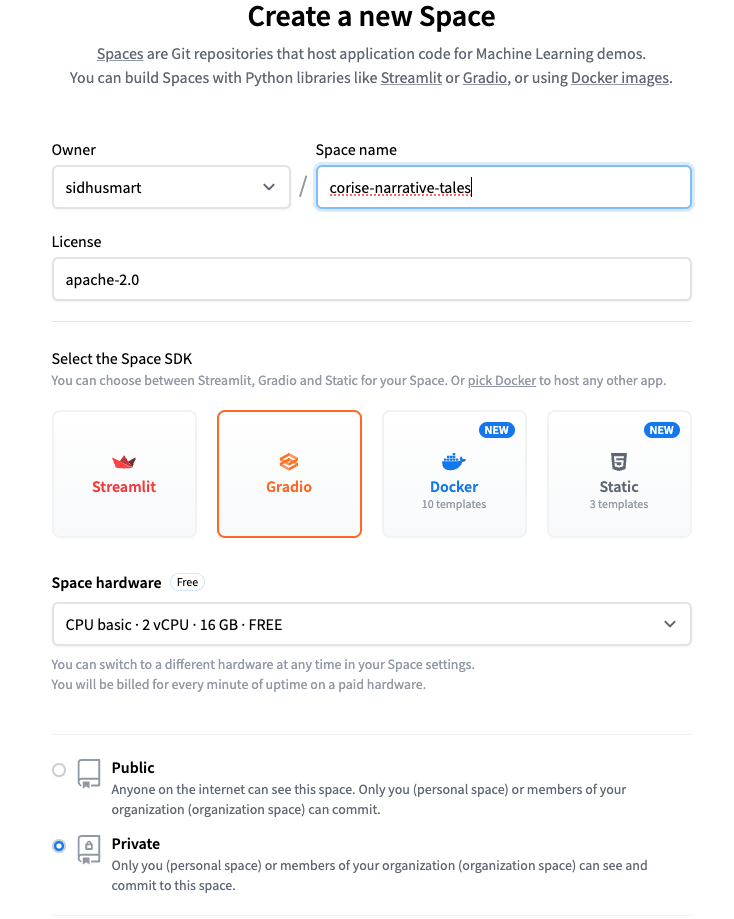

## Using ElevenLabs for voice generation

You can choose to perform the voice generation using voices from 11Labs (11.ai). They are a startup that provide a large variety of realistic voices with the right intonation while speaking. They also offer the possibility to train your own voice using the Studio/Web version but you can choose from the multiple options available to start with.

In order to sign-up, please visit this [link](https://beta.elevenlabs.io/) and create an account. Every new account receives free credits to run voice generations for upto 10k words which should fit well for the purposes of this project. Once the sign-up is complete, please click on the Account name and `Profile` tab from where you can copy the API key.

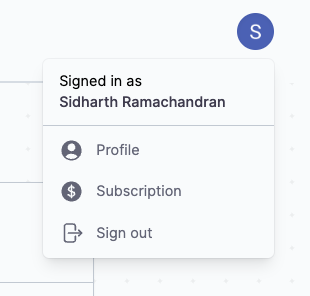

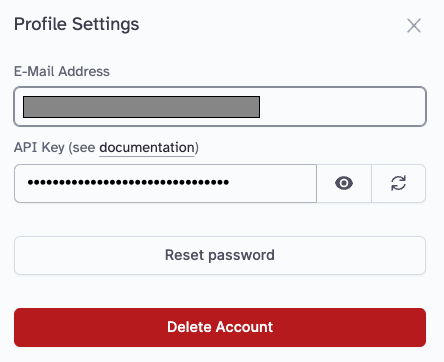

In [14]:
!pip install elevenlabs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.8 MB/s eta 0:00:00


In [ ]:
from elevenlabs import set_api_key

set_api_key(getpass('Enter your ELEVEN_LABS_API_KEY  '))

You can select from a list of speakers that are offered by Eleven Labs as listed [here](https://beta.elevenlabs.io/) in their demo dropdown. Hit the play button to hear the voice and choose a speaker that appeals to you!

In order to perform the voice generation, you can use the method below. This assumes that each line of the input text is spoken by a different person and the person's name is also part of the text itself. Please ensure that the output of your podcast script fits this style or else feel free to adjust the method.

Once you have selected the speaker voices then please make changes below to specify the name of the speakers you chose while generating the podcast script. This will ensure those names are actually removed before the dialogue is spoken!

In [ ]:
from elevenlabs import generate

def createPodcast(podcastScript, speakerName1, speakerChoice1, speakerName2, speakerChoice2):
  genPodcast = []
  podcastLines = podcastScript.split('\n\n')
  podcastLineNumber = 0
  for line in podcastLines:
    if podcastLineNumber % 2 == 0:
      speakerChoice = speakerChoice1
      line = line.replace(speakerName1+":", '')
    else:
      speakerChoice = speakerChoice2
      line = line.replace(speakerName2+":", '')
    genVoice = generate(text=line, voice=speakerChoice, model="eleven_monolingual_v1")
    genPodcast.append(genVoice)
    podcastLineNumber += 1
  return genPodcast

In [ ]:
speakerName1 = "YOUR_SPEAKER_ONE_NAME"
speakerChoice1 = "SPEAKER_ONE_VOICE"
speakerName2 = "YOUR_SPEAKER_TWO_NAME"
speakerChoice2 = "SPEAKER_TWO_VOICE"
genPodcast = createPodcast(podcastScript, speakerName1, speakerChoice1, speakerName2, speakerChoice2)

In [ ]:
with open("/content/sample_data/genPodcast.mpeg", "wb") as f:
  for pod in genPodcast:
    f.write(pod)

With the previous step, you will find the generated podcast available in the folder section on the left bar of Google Colab (refer to the screenshot where you uploaded the PDF file).
All your generated recordings are also available on https://beta.elevenlabs.io/history but this can be a bit buggy at times so I would highly recommend that you save and download your generated audio file as well.

## Multiple Data Sources

In the project we only used PDFs as our data source. But in general, the app could offer users the ability to provide multiple types of data like public URLs, Word documents, Wikipedia etc. We provide code below for working with Wikipedia and generic text documents from a book corpus.

### Wikipedia

In [ ]:
!pip install wikipedia

Let's confirm we can extract the content using Wikipedia's page about itself!

In [ ]:
import wikipedia
print (wikipedia.summary("Wikipedia"))

In [ ]:
# Replace the Wiki page below with the name of the Wiki page you would like to use
input = wikipedia.page("YOUR_WIKI_PAGE_HERE", auto_suggest=False)

In [ ]:
wiki_input = input.content
wiki_input

### Generic Text File

In order to provide an even more generic option, we consider loading information of a book from Project Gutenberg which is available in the form of a text file. This can easily cover almost any other text based source of knowledge.

Please replace the book of your choice by browsing through the Porject Gutenberg library.

In [ ]:
import requests

def get_gutenberg_text(url):
    response = requests.get(url)
    response.encoding = 'utf-8'
    raw_text = response.text

    start_delimiter = "*** START OF THE PROJECT GUTENBERG EBOOK"
    end_delimiter = "*** END OF THE PROJECT GUTENBERG EBOOK"

    start_index = raw_text.find(start_delimiter)
    end_index = raw_text.find(end_delimiter)

    if start_index == -1 or end_index == -1:
        raise ValueError("Could not find start or end delimiter in the text.")

    start_index = raw_text.find("\n", start_index) + 1
    end_index = raw_text.rfind("\n", 0, end_index)

    return raw_text[start_index:end_index]

In [ ]:
# Replace the URL below with the specific Project Gutenberg book URL you want to read
book_url = "YOUR_BOOK_OF_CHOICE"
book_input = get_gutenberg_text(book_url)

print(book_input[:500])  # Print the first 500 characters of the book